In [3]:
#from sklearnex import patch_sklearn
#patch_sklearn()

import pandas as pd
import numpy as np
pd.options.display.max_columns = 30
#data = pd.read_csv('data/spotify_data.csv')
#data = pd.read_csv('data/spotify_clean.csv')
data = pd.read_csv('data/spotify_data.csv')
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Preprocessing steps
splitting train and test data and preprocess them separately: remove duplicates(train set only), transform boolean variable into 1/0 values, drop string values and scale numerical data with Z-scaler


In [3]:
# create a variable with the values of the target variable track_genre
data_target = data['track_genre']

In [4]:
# and remove it from the dataframe so it only contains the features that our model should use
data = data.drop(columns='track_genre')

In [5]:
# split data into train set and test set in proportion 80/20
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, data_target,test_size=0.2, random_state=42, stratify=data_target)

In [6]:
# Combine the training data and target into a single DataFrame for easy duplicate removal
train_df = pd.concat([pd.DataFrame(data_train), pd.Series(target_train, name='target')], axis=1)

# Remove duplicates from the training set
train_df_no_duplicates = train_df.drop_duplicates(['track_id'])

# Separate the features and target variable after removing duplicates
data_train = train_df_no_duplicates.drop(columns=['target'])
target_train = train_df_no_duplicates['target']

In [7]:
# perform normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()




In [8]:
#Preprocessing train data set
# change True/False values of the boolean variable to 1 and 0
data_train['explicit'] = (data_train['explicit']).astype(np.int8)

# remove string features(artist, album_name, track_name) and irrelevant features(track_id, index) that we are not going to use for k NN classifier
data_train = data_train.drop(columns=['artists', 'album_name', 'track_name', 'track_id', 'Unnamed: 0'])

# normalize train set
data_train = scaler.fit_transform(data_train)

In [9]:
#Preprocessing train data set
# change True/False values of the boolean variable to 1 and 0
data_test['explicit'] = (data_test['explicit']).astype(np.int8)

# remove string features(artist, album_name, track_name) and irrelevant features(track_id, index) that we are not going to use for k NN classifier
data_test = data_test.drop(columns=['artists', 'album_name', 'track_name', 'track_id', 'Unnamed: 0'])

# normalize test set
data_test = scaler.fit_transform(data_test)

# k Nearest Neighbors Classifier

In [10]:
# introduce the classifier with default values
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(data_train, target_train)

KNeighborsClassifier()

In [20]:
# evaluate perfomance of classifier with default values
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

target_prediction = knn.predict(data_test)

base_accuracy = accuracy_score(target_test, target_prediction)
base_f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Baseline performance using k Nearest Neighbors")
print(f"Accuracy: {base_accuracy:.2f}")
print(f"F1-score: {base_f1_weighted:.2f}")

#print(confusion_matrix(target_test, target_prediction))
#print(classification_report(target_test, target_prediction))

Baseline performance using k Nearest Neighbors
Accuracy: 0.46
F1-score: 0.46


In [ ]:
# use Grid Search Cross-Validation for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

X = data_train
y = target_train

knn = KNeighborsClassifier(weights='distance', p=1)

k_range = list(range(10,20))
#weight_options = ["uniform", "distance"]
#leaf_size=[10,20,30,40,50,60]
#p=[1,2,3,4,5]
#algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']

stratified_5_fold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#param_grid = dict(n_neighbors = k_range, weights = weight_options,algorithm= algorithm ,leaf_size = leaf_size , p =p)
param_grid = dict(n_neighbors = k_range)



grid_search_estimator = GridSearchCV(knn, param_grid, cv = stratified_5_fold_cv, scoring = 'f1_weighted', return_train_score=False)
grid_search_estimator.fit(X,y)

# # print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#results = pd.DataFrame(random_search_estimator.cv_results_)
display(results)


print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

In [12]:
# use Grid Search Cross-Validation for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

X = data_train
y = target_train

knn = KNeighborsClassifier(weights='distance', p=1)

k_range = list(range(10,20))

stratified_5_fold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


param_grid = dict(n_neighbors = k_range)


grid_search_estimator = GridSearchCV(knn, param_grid, cv = stratified_5_fold_cv, scoring = 'f1_weighted', return_train_score=False)
grid_search_estimator.fit(X,y)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

display(results)


print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.529172,0.179348,60.856533,4.781638,10,{'n_neighbors': 10},0.472388,0.478668,0.473212,0.476559,0.480322,0.476230,0.003055,10
1,0.586982,0.255898,57.709775,3.899264,11,{'n_neighbors': 11},0.474946,0.479637,0.474496,0.478463,0.482009,0.477910,0.002847,8
2,0.396776,0.043302,57.599464,2.085454,12,{'n_neighbors': 12},0.474290,0.479474,0.474828,0.478848,0.481799,0.477848,0.002865,9
3,0.447640,0.035758,57.696158,3.887982,13,{'n_neighbors': 13},0.476403,0.481921,0.475271,0.479152,0.483552,0.479260,0.003149,7
4,0.469402,0.148919,58.488751,2.325209,14,{'n_neighbors': 14},0.477241,0.482607,0.475127,0.480962,0.484301,0.480048,0.003393,6
5,0.482646,0.088750,58.080715,1.831287,15,{'n_neighbors': 15},0.478061,0.482926,0.476549,0.482583,0.484777,0.480979,0.003128,3
6,0.448617,0.066528,61.877494,3.542331,16,{'n_neighbors': 16},0.478918,0.483599,0.478540,0.482610,0.482214,0.481176,0.002052,1
7,0.650988,0.227684,55.384170,3.385401,17,{'n_neighbors': 17},0.478985,0.482198,0.479081,0.482254,0.482130,0.480930,0.001550,4
8,0.386345,0.031357,54.164709,2.636708,18,{'n_neighbors': 18},0.478790,0.482702,0.477411,0.482968,0.480683,0.480511,0.002165,5
9,0.432186,0.083098,54.235468,2.671531,19,{'n_neighbors': 19},0.478866,0.484146,0.479497,0.481313,0.481132,0.480991,0.001834,2


best score is 0.48117609556717345 with params {'n_neighbors': 16}


In [ ]:
# run the model with the best hyperparameter
knn = KNeighborsClassifier(n_neighbors=16, weights='distance', p=1)
knn.fit(data_train, target_train)
target_prediction = knn.predict(data_test)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on unbalanced data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

# Reducing dimensionality of data set with Principal Component Analysis

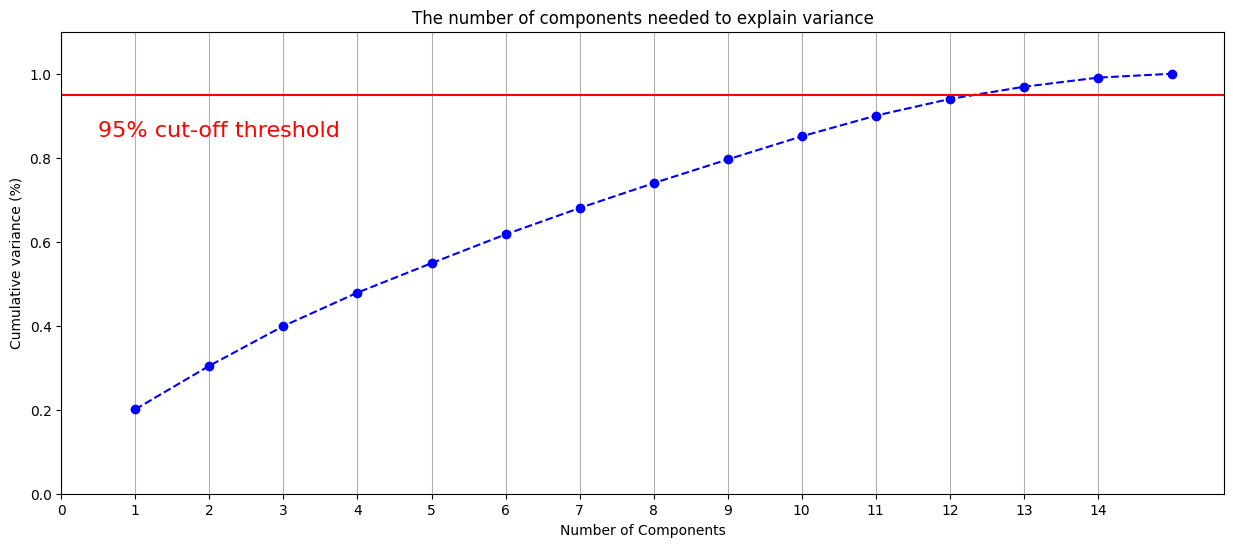

In [16]:
# reducing dimensionality using PCA: plot cumulative variance values depending on number of components
from sklearn.decomposition import PCA
pca = PCA().fit(data_train)

#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 15, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [17]:
# transform train and test data set to reduced data sets (0.95 cumulative variance, - 13 components) 
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)

data_train_reduced = pca.fit_transform(data_train)
data_test_reduced = pca.transform(data_test)

explained_variance = pca.explained_variance_ratio_

print(explained_variance)
print("Training Data Shape:", data_train.shape, "Original Test Data Shape:", data_test.shape)
print("Reduced Training Data Shape:", data_train_reduced.shape, "Reduced Test Data Shape:", data_test_reduced.shape)

Training Data Shape: (71792, 15) Original Test Data Shape: (17948, 15)
Reduced Training Data Shape: (71792, 13) Reduced Test Data Shape: (17948, 13)


In [20]:
# tune hyperparameters on reduced data set
X = data_train_reduced
y = target_train
knn = KNeighborsClassifier(weights='distance', p=1)
grid_search_estimator.fit(X,y)

results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score for reduced data set is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.382634,0.070687,26.809729,2.035789,10,{'n_neighbors': 10},0.446081,0.451144,0.442714,0.451735,0.445250,0.447385,0.003496,9
1,0.352346,0.040376,25.650929,1.465848,11,{'n_neighbors': 11},0.445568,0.450439,0.443779,0.450885,0.445787,0.447292,0.002842,10
2,0.341279,0.057870,24.055796,0.888122,12,{'n_neighbors': 12},0.446030,0.450815,0.443548,0.450293,0.447786,0.447694,0.002700,8
3,0.333308,0.027318,24.650230,1.010848,13,{'n_neighbors': 13},0.446707,0.452224,0.446196,0.450818,0.448644,0.448918,0.002320,7
4,0.330396,0.028441,24.626776,0.505330,14,{'n_neighbors': 14},0.447570,0.452797,0.447796,0.449445,0.448493,0.449220,0.001904,6
5,0.321450,0.009312,25.295014,0.401156,15,{'n_neighbors': 15},0.447834,0.452722,0.449780,0.450492,0.449504,0.450067,0.001588,3
6,0.319324,0.024697,25.537200,0.436036,16,{'n_neighbors': 16},0.448215,0.452332,0.448232,0.450637,0.449241,0.449731,0.001573,4
7,0.343886,0.070097,27.585493,2.717617,17,{'n_neighbors': 17},0.449070,0.452839,0.445874,0.450550,0.449309,0.449528,0.002263,5
8,0.492455,0.228493,238.533934,420.642041,18,{'n_neighbors': 18},0.448971,0.452903,0.448125,0.451159,0.450818,0.450395,0.001687,2
9,0.317123,0.008396,26.805509,1.120413,19,{'n_neighbors': 19},0.449333,0.454066,0.447516,0.452064,0.451041,0.450804,0.002248,1


best score for reduced data set is 0.45080380230788963 with params {'n_neighbors': 19}


In [21]:
knn = KNeighborsClassifier(n_neighbors=19, weights='distance', p=1)
knn.fit(data_train_reduced, target_train)
target_prediction = knn.predict(data_test_reduced)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on unbalanced reduced data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

Performance using k Nearest Neighbors on unbalanced reduced data set
Accuracy: 0.47 i.e. 0.010084689101849786 better than baseline
F1-score: 0.46 i.e. 0.006620137065131149 better than baseline


# Balancing data: oversampling

In [23]:
# try oversampling on complete data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_train_ros, target_train_ros = ros.fit_resample(data_train, target_train)
print("Original Training Data Shape:", data_train.shape, "Original Target Shape:", target_train.shape)
print("Resampled Training Data Shape (oversampling):", data_train_ros.shape, "Resampled Target Shape(oversampled):", target_train_ros.shape)

Original Training Data Shape: (71792, 15) Original Target Shape: (71792,)
Resampled Training Data Shape (oversampling): (198680, 15) Resampled Target Shape(oversampled): (198680,)


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# tune hyperparameters on oversampled data test
X = data_train_ros
y = target_train_ros
knn = KNeighborsClassifier(weights='distance', p=1)

grid_search_estimator.fit(X,y)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#results = pd.DataFrame(random_search_estimator.cv_results_)
display(results)

print("best score for balanced data set (oversampling) is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', p=1)
knn.fit(data_train_ros, target_train_ros)
target_prediction = knn.predict(data_test)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on oversampled complete data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

# Oversampling combined with PCA

In [ ]:
# transform balanced train (oversampling) to reduced data set
pca = PCA(n_components = 0.95)

data_train_ros_reduced = pca.fit_transform(data_train_ros)
data_test_ros_reduced = pca.transform(data_test)

explained_variance = pca.explained_variance_ratio_
print("Resampled Training Data Shape (oversampling):", data_train_ros.shape, "Original Test Data Shape:", data_test.shape)
print("Reduced resampled Training Data Shape (undersampling):", data_train_ros_reduced.shape, "Reduced Test Data Shape:", data_test_ros_reduced.shape)

Resampled Training Data Shape (oversampling): (91200, 15) Original Test Data Shape: (17948, 15)
Reduced resampled Training Data Shape (undersampling): (91200, 13) Reduced Test Data Shape: (17948, 13)


In [ ]:
# tune hyperparameters on oversampled reduced data test
X = data_train_ros_reduced
y = target_train_ros
knn = KNeighborsClassifier(weights='distance', p=1)
grid_search_estimator.fit(X,y)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score for reduced balanced data set (oversampling) is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=21, weights='distance', p=1)
knn.fit(data_train_ros_reduced, target_train_ros)
target_prediction = knn.predict(data_test_ros_reduced)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on oversampled reduced data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

Performance using k Nearest Neighbors on oversampled reduced data set
Accuracy: 0.31 i.e. 0.03092266547804773 better than baseline
F1-score: 0.31 i.e. 0.03310570809954755 better than baseline


# Balancing data: undersampling

In [ ]:
# try undersampling on complete data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
data_train_rus, target_train_rus = rus.fit_resample(data_train, target_train)
print("Original Training Data Shape:", data_train.shape, "Original Target Shape:", target_train.shape)
print("Resampled Training Data Shape (undersampling):", data_train_rus.shape, "Resampled Target Shape(undersampled):", target_train_rus.shape)

Original Training Data Shape: (71792, 15) Original Target Shape: (71792,)
Resampled Training Data Shape (undersampling): (22344, 15) Resampled Target Shape(undersampled): (22344,)


In [ ]:
# tune hyperparameters on undersampled data test
X = data_train_rus
y = target_train_rus
knn = KNeighborsClassifier(weights='distance', p=1)
grid_search_estimator.fit(X,y)

# # print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

display(results)


print("best score for balanced data set (undersampling) is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=14, weights='distance', p=1)
knn.fit(data_train_rus, target_train_rus)
target_prediction = knn.predict(data_test)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on undersampled complete data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

Performance using k Nearest Neighbors on undersampled complete data set
Accuracy: 0.30 i.e. 0.01927791397370182 better than baseline
F1-score: 0.29 i.e. 0.01666525935648039 better than baseline


# Undersampling combined with PCA

In [ ]:
# transform balanced train (undersampling) and test data set according to PCA with X components
pca = PCA(n_components = 0.95)

data_train_rus_reduced = pca.fit_transform(data_train_rus)
data_test_rus_reduced = pca.transform(data_test)

explained_variance = pca.explained_variance_ratio_

print("Resampled Training Data Shape (undersampling):", data_train_rus.shape, "Original Test Data Shape:", data_test.shape)
print("Reduced resampled Training Data Shape (undersampling):", data_train_rus_reduced.shape, "Reduced Test Data Shape:", data_test_rus_reduced.shape)

Resampled Training Data Shape (undersampling): (22344, 15) Original Test Data Shape: (17948, 15)
Reduced resampled Training Data Shape (undersampling): (22344, 13) Reduced Test Data Shape: (17948, 13)


In [ ]:
# tune hyperparameters on undersampled reduced data test
X = data_train_rus_reduced
y = target_train_rus
knn = KNeighborsClassifier(weights='distance', p=1)
grid_search_estimator.fit(X,y)

# # print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

print("best score for reduced balanced data set (undersampling) is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13, weights='distance', p=1)
knn.fit(data_train_rus_reduced, target_train_rus)
target_prediction = knn.predict(data_test)

accuracy = accuracy_score(target_test, target_prediction)
f1_weighted = f1_score(target_test, target_prediction, average='weighted')
print("Performance using k Nearest Neighbors on undersampled reduced data set")
print(f"Accuracy: {accuracy:.2f} i.e. {accuracy-base_accuracy} better than baseline")
print(f"F1-score: {f1_weighted:.2f} i.e. {f1_weighted-base_f1_weighted} better than baseline")

Performance using k Nearest Neighbors on undersampled reduced data set
Accuracy: 0.26 i.e. -0.014709159794963178 better than baseline
F1-score: 0.26 i.e. -0.016558222811761114 better than baseline


# The best performance was shown by the classifier trained on unbalanced data without application principal component analysis 